# Natural Language Processing with Disaster Tweets

# Importing Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') 
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

/Users/jaynasser/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaynasser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jaynasser/nltk_data...


# Loading data and getting sense 

In [2]:
##load the train data and look for the column data
tweet = pd.read_csv('train.csv')
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [3]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))

There are 7613 rows and 5 columns in train


1. Let us see how data is distributed over the Non-Disaster and Disasters tweets.The main point of this analysis is to understand the possibility of data skew

Number of non targets:  4342
Number of targets:  3271


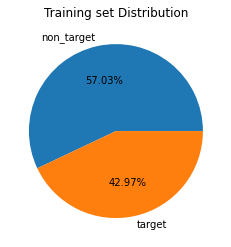

In [4]:
def label_distribution(labels):
      zero_count = 0
      one_count = 0

      for label in labels:
        if label == 0:
          zero_count += 1
        elif label == 1:
          one_count += 1

      print("Number of non targets: ", zero_count)  
      print("Number of targets: ", one_count)
      plt.pie([zero_count, one_count], labels=['non_target', 'target'], autopct='%0.2f%%')
      plt.title('Training set Distribution')
      plt.show()


label_distribution(tweet['target'])

So, the data set is evenly distributed. Now let us see if the disaster/ non disaster tweets possess any special properties that we can use in our feature extraction

2. We will compare the word counts for the disaster and non disaster tweets

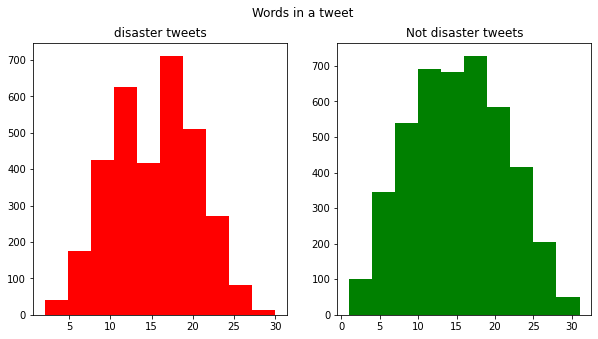

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

3. Does Disaster tweets contain any special characters?? Lets try to get top 10 frequent words on both the type of data

In [6]:
all_text = ' '.join(tweet[tweet['target']==1]['text'])

# Convert to lowercase
words = re.findall(r'\w+', all_text.lower()) 

# Filter out the stopwords from your word list
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) >2]


# Count the frequency of each word
word_count = Counter(filtered_words)

# Find the top 10 most frequent words
top_10_words = word_count.most_common(50)

print(top_10_words)

analyzer = SentimentIntensityAnalyzer()
negative_word_count =0
for word in filtered_words:
    sentiment = analyzer.polarity_scores(word)
    if sentiment['compound'] < 0:
        negative_word_count += 1
print("Ratio of Negative words across all the sentences", negative_word_count/tweet[tweet['target']==1].shape[0])

[('http', 2382), ('fire', 182), ('news', 140), ('amp', 135), ('https', 134), ('disaster', 121), ('via', 121), ('california', 115), ('suicide', 112), ('police', 109), ('people', 105), ('killed', 95), ('like', 94), ('hiroshima', 92), ('storm', 89), ('fires', 86), ('crash', 85), ('families', 81), ('train', 79), ('emergency', 77), ('bomb', 76), ('buildings', 76), ('two', 74), ('nuclear', 73), ('mh370', 72), ('attack', 71), ('video', 69), ('wildfire', 69), ('accident', 68), ('bombing', 67), ('old', 67), ('get', 66), ('one', 65), ('northern', 64), ('burning', 64), ('dead', 63), ('legionnaires', 61), ('car', 60), ('bomber', 60), ('war', 59), ('year', 58), ('homes', 58), ('typhoon', 58), ('still', 57), ('obama', 57), ('new', 56), ('atomic', 56), ('japan', 56), ('fatal', 55), ('today', 55)]
Ratio of Negative words across all the sentences 1.1216753286456742


In [7]:
all_text = ' '.join(tweet[tweet['target']==0]['text'])

# Convert to lowercase
words = re.findall(r'\w+', all_text.lower()) 

# Filter out the stopwords from your word list
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) >2]


# Count the frequency of each word
word_count = Counter(filtered_words)

# Find the top 10 most frequent words
top_10_words = word_count.most_common(50)

print(top_10_words)

analyzer = SentimentIntensityAnalyzer()
negative_word_count =0
for word in filtered_words:
    sentiment = analyzer.polarity_scores(word)
    if sentiment['compound'] < 0:
        negative_word_count += 1
print("Ratio of Negative words across all the sentences", negative_word_count/tweet[tweet['target']==0].shape[0])

[('http', 1927), ('https', 277), ('like', 254), ('amp', 209), ('new', 170), ('get', 163), ('one', 131), ('body', 116), ('would', 101), ('via', 99), ('video', 96), ('people', 95), ('love', 90), ('day', 86), ('know', 86), ('time', 85), ('back', 85), ('got', 84), ('full', 84), ('see', 82), ('emergency', 81), ('going', 76), ('youtube', 76), ('let', 76), ('still', 72), ('fire', 72), ('want', 67), ('good', 67), ('man', 66), ('think', 66), ('world', 63), ('lol', 62), ('life', 61), ('first', 59), ('way', 57), ('burning', 57), ('news', 57), ('last', 56), ('make', 56), ('best', 55), ('really', 55), ('need', 55), ('reddit', 55), ('work', 54), ('take', 52), ('much', 51), ('many', 51), ('even', 51), ('help', 49), ('say', 49)]
Ratio of Negative words across all the sentences 0.7759097190234915


Looks like there is a clear difference in frequency of words in disaster tweets and non disaster ones. We are seeing lot of panic words like "accident", "crash", "fires", "disaster" etc.
Also ratio of negative words for disaster statement >> non-disaster statement

# DataCleaning

From the first look at the data we can see that there are lot of non text words in the text field. So, let us filter clean the data 

In [8]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [9]:
# Clear emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Clear html
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)


# Clear urls
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


# Clear special characters
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def clean_df(df):
    # lower the characters
    df["text"] = df["text"].apply(lambda x: x.lower())
    df["text"] = df["text"].apply(lambda x: remove_emoji(x))
    df["text"] = df["text"].apply(lambda x: remove_html(x))
    df["text"] = df["text"].apply(lambda x: remove_URL(x))
    df["text"] = df["text"].apply(lambda x: remove_punct(x))
    # Remove multiple spaces
    df["text"] = df.text.replace("\s+", " ", regex=True)
    return df

tweet = clean_df(tweet)
tweet.fillna('', inplace=True)
tweet.head(10)

,id,keyword,location,text,target
0,1,,,our deeds are the reason of this earthquake ma...,1
1,4,,,forest fire near la ronge sask canada,1
2,5,,,all residents asked to shelter in place are be...,1
3,6,,,13000 people receive wildfires evacuation orde...,1
4,7,,,just got sent this photo from ruby alaska as s...,1
5,8,,,rockyfire update california hwy 20 closed in b...,1
6,10,,,flood disaster heavy rain causes flash floodin...,1
7,13,,,im on top of the hill and i can see a fire in ...,1
8,14,,,theres an emergency evacuation happening now i...,1
9,15,,,im afraid that the tornado is coming to our area,1


# Diving Training to Train and Test Sets

In [10]:
'''
def combine_attributes(text, keyword):
    var_list = [text, keyword]
    combined = ' '.join(x for x in var_list if x)
    return combined

tweet['combine'] = tweet.apply(lambda x: combine_attributes(x['text'], x['keyword']), axis=1)
'''
tweet_train, tweet_test, y_train, y_test = train_test_split(tweet['text'], tweet['target'], test_size=0.2, random_state=99)

# Implementing vectorization and LogReg

In [15]:
vectorizer = TfidfVectorizer()
tweet_train_vect = vectorizer.fit_transform(tweet_train)
tweet_test_vect = vectorizer.transform(tweet_test)

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=16)
logreg.fit(tweet_train_vect, y_train)

y_pred = logreg.predict(tweet_test_vect)

# Calculating Scores

In [17]:
def scores(y_test, y_predicted):  
    accuracy = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    precision = precision_score(y_test, y_predicted, pos_label = None, average = 'weighted')             
    recall = recall_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    print("accuracy = %.4f, f1 = %.4f, precision = %.4f, recall = %.4f" % (accuracy, f1, precision, recall))
    return accuracy, f1, precision, recall

In [18]:
accuracy, f1, precision, recall = scores(y_test, y_pred)

accuracy = 0.7919, f1 = 0.7888, precision = 0.7948, recall = 0.7919
